In [ ]:
%pip install XGBoost

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


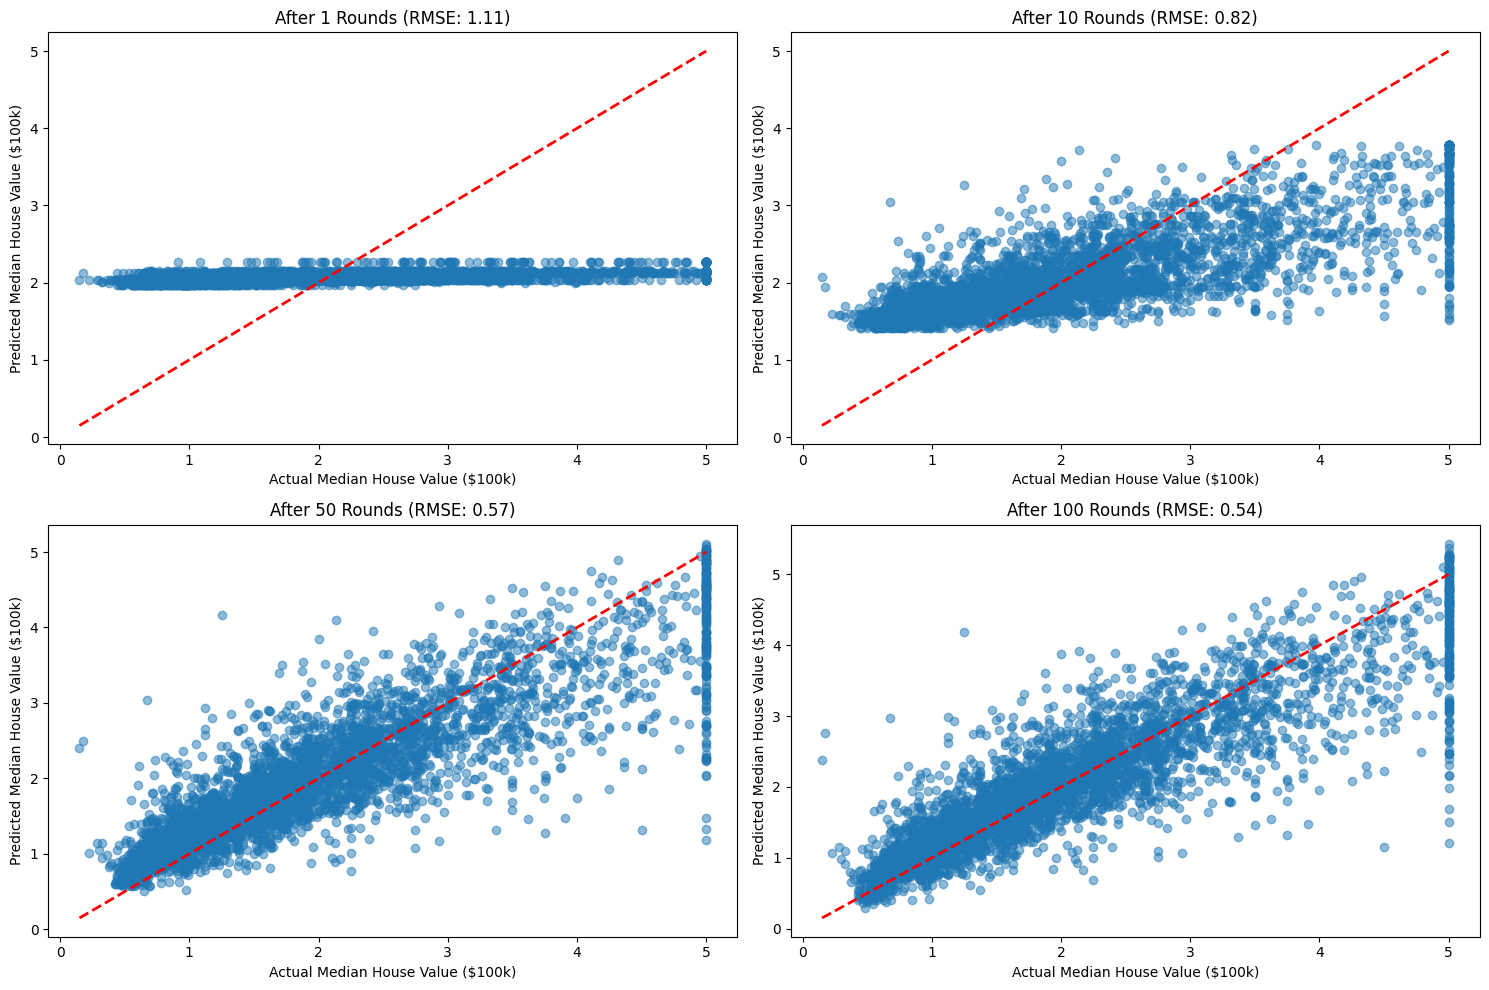

First Tree Structure (Text Representation):
0:[AveRooms<6.3791666] yes=1,no=2,missing=2,gain=2209.76294,cover=13167
	1:[AveOccup<2.4484849] yes=3,no=4,missing=4,gain=1120.37183,cover=10786
		3:[Latitude<37.9399986] yes=7,no=8,missing=8,gain=769.874512,cover=3034
			7:leaf=0.0580857694,cover=2420
			8:leaf=-0.0672156736,cover=614
		4:[Latitude<38.4799995] yes=9,no=10,missing=10,gain=287.964355,cover=7752
			9:leaf=-0.0328604132,cover=7049
			10:leaf=-0.0999516547,cover=703
	2:[AveBedrms<1.26073623] yes=5,no=6,missing=6,gain=762.538574,cover=2381
		5:[AveRooms<7.40989399] yes=11,no=12,missing=12,gain=488.127441,cover=1957
			11:leaf=0.0826703683,cover=1408
			12:leaf=0.193900779,cover=549
		6:[Latitude<37.8199997] yes=13,no=14,missing=14,gain=52.6188812,cover=424
			13:leaf=-0.00499816192,cover=254
			14:leaf=-0.0767742544,cover=170



<Figure size 1000x600 with 0 Axes>

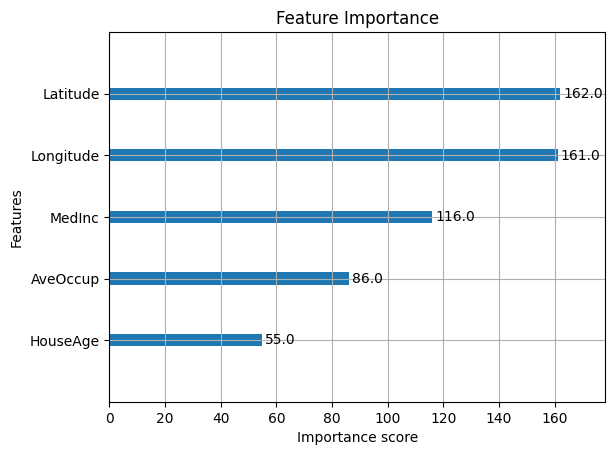

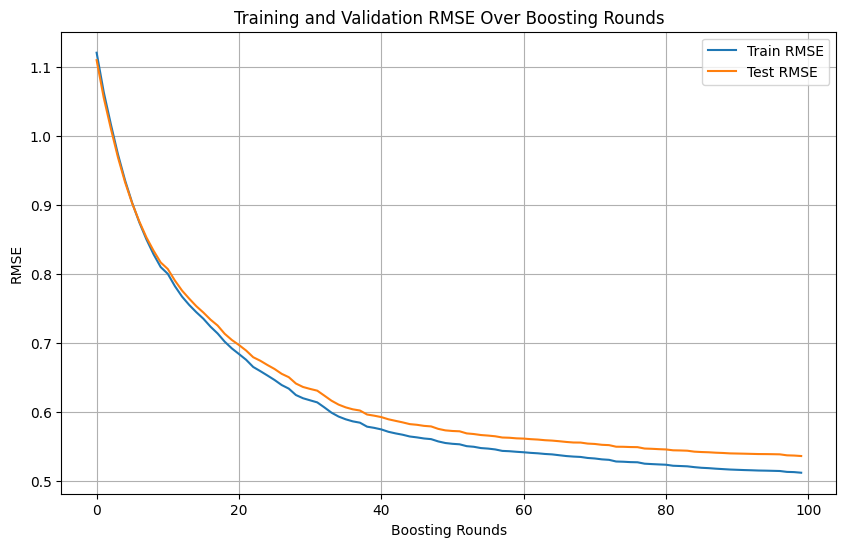

Final Train RMSE: 0.51
Final Test RMSE: 0.54


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import plot_importance

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load the California Housing dataset
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target  # Target is median house value in $100,000s
print(X.head())

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Convert data into XGBoost's DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 4: Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression
    'max_depth': 3,                   # Depth of each tree
    'eta': 0.1,                       # Learning rate
    'subsample': 0.8,                 # Use 80% of data to grow trees
    'colsample_bytree': 0.8,          # Use 80% of features per tree
}

# Step 5: Train the model iteratively and store evaluation results in a dictionary
num_rounds = 100
early_stopping_rounds = 10

# Create a dictionary to store evaluation results
evals_result = {}

# Train the model with evaluation
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_rounds,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=False,
    evals_result=evals_result  # Pass the dictionary to store results
)

# Step 6: Visualize predictions at different stages
# Predict after 1, 10, 50, and 100 rounds by retraining with fewer rounds
stages = [1, 10, 50, 100]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, n_rounds in enumerate(stages):
    # Train the model up to n_rounds
    temp_model = xgb.train(params, dtrain, num_boost_round=n_rounds)
    
    # Predict on test set
    y_pred = temp_model.predict(dtest)
    
    # Scatter plot: Actual vs Predicted
    axes[idx].scatter(y_test, y_pred, alpha=0.5)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Median House Value ($100k)')
    axes[idx].set_ylabel('Predicted Median House Value ($100k)')
    axes[idx].set_title(f'After {n_rounds} Rounds (RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f})')

plt.tight_layout()
plt.show()

# Step 7: Alternative to Graphviz - Print and Visualize Tree Structure Without Graphviz
# We'll extract the tree structure and print the first tree as text
# Additionally, we'll create a simple custom visualization for splits
print("First Tree Structure (Text Representation):")
trees = model.get_dump(with_stats=True)  # Get the dump of all trees
first_tree = trees[0]  # Get the first tree
print(first_tree)  # Print the first tree as text


# Step 8: Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=5)  # Show top 5 most important features
plt.title("Feature Importance")
plt.show()

# Step 9: Plot training and validation RMSE over boosting rounds
# Use the evals_result dictionary to access the metrics
train_rmse = evals_result['train']['rmse']
test_rmse = evals_result['test']['rmse']
rounds = range(len(train_rmse))

plt.figure(figsize=(10, 6))
plt.plot(rounds, train_rmse, label='Train RMSE')
plt.plot(rounds, test_rmse, label='Test RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE Over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Step 10: Final evaluation
final_train_pred = model.predict(dtrain)
final_test_pred = model.predict(dtest)
print(f"Final Train RMSE: {np.sqrt(mean_squared_error(y_train, final_train_pred)):.2f}")
print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, final_test_pred)):.2f}")